# Minipset 2: Semantic Segmentation
## Due Wednesday, April 29, 11:59 p.m.

## Introduction <a id='introduction'/>

In this notebook we would like to give you an introduction into how some of the fundamental building blocks of semantic segmentation work, as well as a taste of how to use segmentation in practice. As methods for creating new semantic segmentation networks from scratch is a field within itself, we would instead like to focus on how to use state-of-the-art models, such as RefineNet, and show their potential within robotics. 

1. [Convolution Basics](#convolution)
  1. [Adding kernel to image (5 pts)](#addingKernelToImage)
  2. [Creating vertical kernel (5 pts)](#verticalKernel)
  3. [Theoretical understanding (10 pts)](#theoryKernel)
2. [RefineNet](#refineNetSample)
  1. [RefineNet results (10 pts)](#refineNetRes)
3. [RefineNet in practice](#objectCount)
  1. [Count objects (15 pts)](#objectCount)
  2. [Enclosing box (35 pts)](#enclosingBox)
  3. [Obstacle in the road (20 pts)](#Obstacle)

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from utils.utils import *

## Convolution Basics <a id='convolution'/>

A cornerstone for the recent advances in machine vision is the convolutional layer made popular by AlexNet, which won the ImageNet 2012 competiton by a landslide. The idea is to have a matrix kernel which you slide over an image to extract features, as illustrated in the GIF bellow. 

<img src="https://miro.medium.com/max/526/1*GcI7G-JLAQiEoCON7xFbhg.gif" height="250" width="350">

In the gif above we are using this kernel on the image:
$\begin{bmatrix}
1 & 0 & 1\\
0 & 1 & 0 \\
1 & 0 & 1 \\
\end{bmatrix}$

### Adding kernel to image (5%) <a id='addingKernelToImage'/>
Different kernels can extract different features out of an image. For example:

This kernel can detect horizontal lines:
$\begin{bmatrix}
-1 & -1 & -1\\
2 & 2 & 2 \\
-1 & -1 & -1 \\
\end{bmatrix}$

Let's see it in action! In the following cell, implement the kernel and apply it to our input image: 

<img src="https://github.com/larserikfagernaes/modelsSemanticSegmentation/blob/master/imgs/uniform_rectilinear_grid_2d.png?raw=true" height="250" width="250">

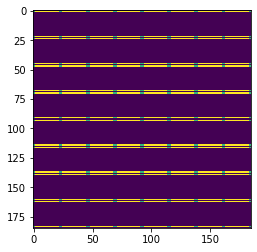

In [2]:
# Read input image as grayscale.
canvas = cv2.imread('modelsSemanticSegmentation/imgs/uniform_rectilinear_grid_2d.png',0)

# Implement the kernel as a numpy array. Then apply the kernel to the image. There are many
# packagages that can do this, but cv2.filter2D() might come in handy.
# kernel_horizontal = 
# img_horizontal_feature = 

### BEGIN TEAM SOLUTION
kernel_horizontal = np.array([[-1,-1,-1],[2,2,2],[-1,-1,-1]])
kernel_horizontal = kernel_horizontal/np.linalg.norm(kernel_horizontal)
img_horizontal_feature = cv2.filter2D(canvas,-1,kernel_horizontal)
### END TEAM SOLUTION

plt.imshow(img_horizontal_feature)

In [3]:
check_horizontal_kernel(kernel_horizontal,img_horizontal_feature, canvas)
test_ok()

Tests passed!!

### Creating vertical kernel (5%)  <a id='verticalKernel'/>

Now that you've seen how a horizontal kernel is applied to an image, let's create a new kernel that detects vertical lines, but this time you have to figure out what kernel matrix to use.

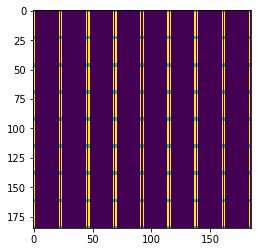

In [4]:
canvas = cv2.imread('modelsSemanticSegmentation/imgs/uniform_rectilinear_grid_2d.png',0)

# kernel_vertical = 
# img_vertical_feature = 

### BEGIN TEAM SOLUTION
kernel_vertical = np.array([[-1,-1,-1],[2,2,2],[-1,-1,-1]]).T/2
kernel_vertical = kernel_vertical/np.linalg.norm(kernel_vertical)
img_vertical_feature = cv2.filter2D(canvas,-1,kernel_vertical)
### END TEAM SOLUTION

plt.imshow(img_vertical_feature)

In [5]:
check_vertical_kernek(kernel_vertical,img_vertical_feature)
test_ok()

Tests passed!!

### Theoretical understanding (10%)  <a id='theoryKernel'/>

Great! Now that we've seen convolutions in practice, it's time to focus on your theoretical understanding. In your own words, what does a convolutional layer do, and why were we able to extract vertical and horizontal features from the examples above? 

####### TEAM SOLUTION

A convolutional layer applies a kernel stepwise over an image. This kernel acts like a filter to extract features from a given image. The features extracted depend on the kernel, where we have seen two that extract horizontal and vertical lines above.

Taking the vertical kernel as an example: This kernel looks at a 3x3 square and multiplies the top row, e.g. pixels: (0,0), (1,0), (2,0) by -1 and the bottom row, e.g. (2,0), (2,1), (2,2) by -1. This punished the 3x3 square of having elements which are not in the middle line e.g. (1,0), (1,1), (1,2). So if one 3x3 square has 3 white pixels (value 1) in as a vertical line in the middle, the convolution returns a value of 6, but if the 3x3 section has all pixels white, the value returned from the kernel is 0. So it detects vertical lines. A similar argument can be made for our horizontal kernel.

As we can see in the plotted images, we have extracted both vertical and horizontal lines. There are other filters which can detect edges, circles, or even more complicated curves. We could imagine that a later layer in our network could use these two convolutional results to detect boxes. If we stack enough convolutional layers after each other we can detect almost any shape. Of course, the point of using these deep-learning techniques is that we don't have to manually define features like lines and circles; instead, the network learns analogous featrues behind the scenes. Nevertheless, the mental model of building increasingly informative features on each layer is a useful one.

There are several other methods used in image recognition tasks, such as max-pooling, dropout layers, etc., but the most basic building block is convolution. Now that we have seen some of this underlying logic, let's jump to using a state-of-the-art segmentation network, RefineNet, on some practice examples. To speed up the process we will use a pretrained network, so don't worry about needing hundreds of hours of GPU time!

## RefineNet on sample images <a id='refineNetSample'/>
(takes 2-3 min to run the first time)

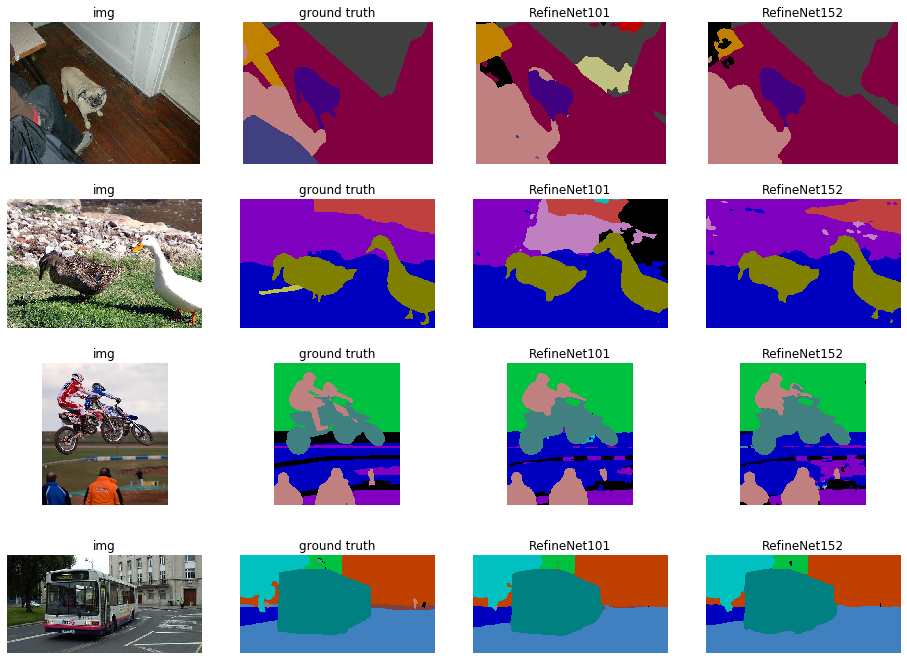

In [8]:
import six
import sys
from modelsSemanticSegmentation.resnet import rf_lw101, rf_lw152
from utils.helpers import prepare_img

%matplotlib inline

import glob
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from PIL import Image

cmap = np.load('utils/cmap.npy')
has_cuda = torch.cuda.is_available()
img_dir = 'modelsSemanticSegmentation/imgs/'
imgs = glob.glob('{}*.jpg'.format(img_dir))
n_classes = 60
# Initialise models
model_inits = { 
    'RefineNet101'   : rf_lw101,
    'RefineNet152'   : rf_lw152,
    }

models = dict() 
for key,fun in six.iteritems(model_inits): # Check for cuda
    net = fun(n_classes, pretrained=True).eval()
    if has_cuda:
        net = net.cuda()
    models[key] = net

def do_calculation(images, models, gt = True):
    n_cols = len(models) + 2 # 1 - for image, 1 - for GT
    n_rows = len(images)
    if (gt == False):
        n_cols -= 1    

    plt.figure(figsize=(16, 12))
    idx = 1

    with torch.no_grad():
        for img_path in images:
            img = np.array(Image.open(img_path))
            msk = np.array(Image.open(img_path.replace('jpg', 'png')))
            orig_size = img.shape[:2][::-1]

            img_inp = torch.tensor(prepare_img(img).transpose(2, 0, 1)[None]).float()
            if has_cuda:
                img_inp = img_inp.cuda()

            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(img)
            plt.title('img')
            plt.axis('off')
            idx += 1
            
            if (gt):
                plt.subplot(n_rows, n_cols, idx)
                plt.imshow(msk)
                plt.title('ground truth')
                plt.axis('off')
                idx += 1

            for mname, mnet in six.iteritems(models):
                segm = mnet(img_inp)[0].data.cpu().numpy().transpose(1, 2, 0)

                segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC)
                segm = cmap[segm.argmax(axis=2).astype(np.uint8)]

                plt.subplot(n_rows, n_cols, idx)
                plt.imshow(segm)
                plt.title(mname)
                plt.axis('off')
                idx += 1
                if (gt == False):
                    return segm

segm = do_calculation(imgs, models)

### RefineNet results (10%) <a id='refineNetRes'/>

Above we can see the results of using RefineNet101 and RefineNet152 on some sample images. Some important notes about how the code works: 
* Line: **segm = mnet(img_inp)[0].data.cpu().numpy().transpose(1, 2, 0)** this is where the model is called on our input image. 
* The model returns a (x,y,60) dimension image. The 60 represents number of classes it is trained on. So it returns an array of length 60 for each pixel, where the items in the array denote the probability of the pixel belonging to that class. For some tasks where you know the number of classes to segment, this hyperparameter could improve results significantly, but would require retraining the network.
* The returned image is a downsampled version, so we need to upscale the segment to fit our original image.
* Line: **segm = cmap[segm.argmax(axis=2).astype(np.uint8)]** here we select the most probable class for each pixel and turn it into a color. Pixels of the same color belong to the same class.

The difference between RefineNet101 and RefineNet152 is the number of layers in their respective Resnets (which is used as the backbone of RefineNet as we saw in our lecture). Based on the results above, how do the two networks compare? Are there some situations Resnet101 would be preferred? And what are some potential dangers you can see with using RefineNet?

####### TEAM SOLUTION

Important points: 
* The 152 gives overall better performance.
* The 101 can actually perform better in some cases, such as image 3 with the motorcycle pixels on the helmet of one rider.
* 101 could be preferred if runtime or memory was very critical.
* Resnet, like all neural networks have the problem of being unpredictable. E.g., on a car this could be dangerous.
* By forcing the network to label pixels, it could be forced to make predictions under bad conditions, such as foggy weather, which could give very strange results.
* It starts by working on a much smaller image and then scales it up. This makes the resolution of our prediction bad.

## RefineNet in practice
Next, let's illustrate how we can use this system with a real example. Say you are an engineer at an autonomous vehicle company tasked with creating the anti-crash system. In particular, your car has front-facing cameras to view the oncoming road, and you would like to know if there is a person standing in the road based on those images. You insert the images from the car's camera into our RefineNet and get the following result:

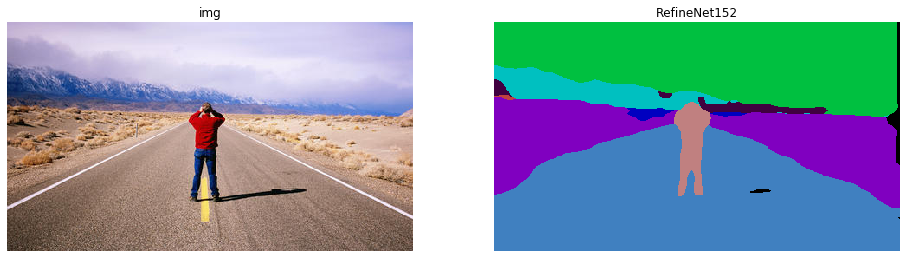

In [9]:
person_image_path = os.path.join(img_dir, "img_person/personInRoad.jpg")
segm = do_calculation([person_image_path], {'RefineNet152': models['RefineNet152']}, False) # Segm is a (264, 469, 3) numpy array.
one_dim_segm = np.dot(segm[...,:3], [0.299, 0.587, 0.114]) # Reshape to (264, 469), easier to work with.

### Object count (15%) <a id='objectCount'/> 
Let's start with writing a function which counts the number of distinct objects in our image. This will introduce us to the method of looping through an image, which we will use in the following two tasks. Use the color of each pixel to tell objects apart.

In [10]:
def numberOfObjects(img):
    ### BEGIN TEAM SOLUTION
    result = set([])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result.add(img[i][j])
    return len(result)
    ### END TEAM SOLUTION

number = numberOfObjects(one_dim_segm)

In [11]:
check_numberOfObjects(numberOfObjects(one_dim_segm))
test_ok()

Tests passed!!

### Enclosing box (35%) <a id='enclosingBox'/>
Now let's create a function which makes a bounding box around an object. Your function should take as input a segmented image and a pixel, and it should return the bounding box of the contiguous region containing the given pixel (i.e. if the pixel lies within a region shaded blue, you should find the bounding box that encloses the entire blue region). If there are two areas labeled as the same type of object, but the regions are not connected in our segmentation, they should get distinct boxes. In Python pixel x=0, y=0 represents the top left corner.

*Hint:* A possible algorithm would check pixels to the right, left, up, and down for the given pixel and recursivley call itself if they're of the same type. One could also solve it with a while loop. Return the that box that encloses the object.

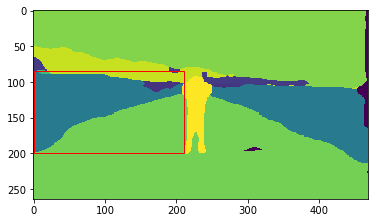

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

class Box:
    def __init__(self, xTopLeft, yTopLeft, xBottomRight, yBottomRight):
        self.xTopLeft = xTopLeft
        self.yTopLeft = yTopLeft
        self.xBottomRight = xBottomRight
        self.yBottomRight = yBottomRight

class Pixel:
    def __init__(self, x, y):
        self.x = x 
        self.y = y 

# Helper function if you want to show the box on the image. 
def showBoxOnImage(box, image):
    boxHeight = box.yTopLeft - box.yBottomRight
    boxWidth = box.xTopLeft - box.xBottomRight

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((box.xBottomRight,box.yBottomRight),boxWidth,boxHeight,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

def exampleEnclosingBoxAroundSide(img, pixel):
    # code to find Box... 
    box = Box(0, 85, 210, 199)
    showBoxOnImage(box, img)
    return box

exampleEnclosingBoxAroundSide(one_dim_segm, Pixel(0, 88))

def enclosingBox(img, pixel):
    ### BEGIN TEAM SOLUTION
    pixel = Pixel(pixel.y, pixel.x)
    record = np.zeros(img.shape, dtype = np.bool)

    frontier = [(pixel.x, pixel.y)]
    record[pixel.x,pixel.y] = True

    max_x = pixel.x
    max_y = pixel.y

    min_x = pixel.x
    min_y = pixel.y

    color = img[pixel.x, pixel.y]

    # BFS
    while frontier:
        x, y = frontier.pop(0)
        neighbors = []

        if x > 0:
            neighbors.append((x-1, y))
        if x < img.shape[0]-1:
            neighbors.append((x+1, y))
        if y > 0:
            neighbors.append((x, y-1))
        if y < img.shape[1]-1:
            neighbors.append((x, y+1))

        for (x1, y1) in neighbors:
            if not record[x1, y1] and img[x1, y1]==color:
                frontier.append((x1 ,y1))
                record[x1, y1]=True
                max_x = max(x1, max_x)
                max_y = max(y1, max_y)
                min_x = min(x1, min_x)
                min_y = min(y1, min_y)

    box = Box(min_y, min_x, max_y, max_x)
    return box
    ### END TEAM SOLUTION

In [13]:
check_enclosingBox(enclosingBox, one_dim_segm)
test_ok()

Tests passed!!

### Obstacle in the road (20%) <a id='Obstacle'/>
Now let's check if any obstacle (bigger than 100px^2 in area) is in the road. You can assume the bottom middle pixel of the image is part of the road. So in our case, if you sample pixel (x = 234, y = 264) you will get part of the road. An object is defined as in the road if both bottom corners of its bounding box are in the road.

*Hint:* one possible way to solve the problem:
1. Get bounding box of road.
2. Loop over all pixels, get bounding box of pixel, and check if bottom two corners are within box of road.
3. If yes, return true.

In [14]:
### BEGIN TEAM SOLUTION
def get_all_box(img):
    result = []
    record = np.zeros(img.shape, dtype = np.bool)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if record[i, j]:
                continue
            pixel = Pixel(i, j)

            frontier = [(pixel.x, pixel.y)]
            record[pixel.x, pixel.y] = True

            max_x = pixel.x
            max_y = pixel.y

            min_x = pixel.x
            min_y = pixel.y

            color = img[pixel.x, pixel.y]

            area = 0
            # BFS
            while frontier:
                x, y = frontier.pop(0)
                neighbors = []
                area += 1
                if x > 0:
                    neighbors.append((x-1, y))
                if x < img.shape[0]-1:
                    neighbors.append((x+1, y))
                if y > 0:
                    neighbors.append((x, y-1))
                if y < img.shape[1]-1:
                    neighbors.append((x, y+1))

                for (x1, y1) in neighbors:
                    if not record[x1, y1] and img[x1, y1]==color:
                        frontier.append((x1, y1))
                        record[x1, y1]=True
                        max_x = max(x1, max_x)
                        max_y = max(y1, max_y)
                        min_x = min(x1, min_x)
                        min_y = min(y1, min_y)

            if area > 100:
                box = Box(min_y, min_x, max_y, max_x)
                result.append(box)

    return result

def point_in_box(box,p):
    if p.x<=box.xBottomRight and p.x>=box.xTopLeft and p.y<=box.yBottomRight and p.y>=box.yTopLeft:
        return True
    else:
        return False
### END TEAM SOLUTION

def personOnRoad(img):
    ### BEGIN TEAM SOLUTION
    road_box = enclosingBox(img, Pixel(234,263))
    all_objects = get_all_box(img)
    for box in all_objects:
        if box.xTopLeft == road_box.xTopLeft \
            and box.yTopLeft == road_box.yTopLeft \
            and box.xBottomRight == road_box.xBottomRight \
            and box.yBottomRight == road_box.yBottomRight:
            continue
        if point_in_box(road_box,Pixel(box.xBottomRight,box.yBottomRight)) and point_in_box(road_box,Pixel(box.xTopLeft,box.yBottomRight)):
            return True
    return False
    pass
    ### END TEAM SOLUTION

In [15]:
check_personOnRoad(personOnRoad, one_dim_segm)
test_ok()

Tests passed!!